In [17]:
# Data procesing, description and ploting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tableone import TableOne as to

# Data preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Feature selection 
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [18]:
# Load  data from the two different Excel files

In [19]:
## Clinical data
df_clinical = pd.read_excel('E:\TFM Marta\Base de dades\RadioponPulmon_SBRT_TFM v6.xlsx')
df_clinical.rename(columns={"RESPUESTA POR TC A 1.5 MESES": "RESPONSE","ID TFM Marta":"ID" }, inplace=True)
df_clinical['ID'] = df_clinical['ID'].astype(float)
print(f"Clinical dataframe shape: {df_clinical.shape}")

## Radiomic data
df_radiomic = pd.read_excel('E:\TFM Marta\Codis\Radiomics_Marta.xlsx')
df_radiomic['case_id'] = df_radiomic['case_id'].str.replace('_MCC$', '', regex=True)
df_radiomic.rename(columns={"case_id": "ID" }, inplace=True)
df_radiomic['ID'] = df_radiomic['ID'].astype(float)
print(f"Radiomic dataframe shape: {df_radiomic.shape}")

# Merging dataframes and filtering ID present in both
df_common = pd.merge(df_clinical[['ID']], df_radiomic[['ID']], on='ID', how='inner') 
df_clinical = df_clinical[df_clinical['ID'].isin(df_common['ID'])]
df_radiomic = df_radiomic[df_radiomic['ID'].isin(df_common['ID'])]

print(f"Common ID dataframe shape: {df_common.shape}")
print(f"Clinical dataframe reshaped: {df_common.shape}")
print(f"Radiomic dataframe reshaped: {df_common.shape}")

Clinical dataframe shape: (148, 35)
Radiomic dataframe shape: (153, 1690)
Common ID dataframe shape: (142, 1)
Clinical dataframe reshaped: (142, 1)
Radiomic dataframe reshaped: (142, 1)


# Clinical data preprocessing (before data splitting)

Index(['Fecha nacimiento', 'FECHA INICIO RT', 'FECHA FINAL RT',
       'FECHA DE EXITUS', 'ÚLTIMO CONTROL', 'FECHA DE RECAIDA'],
      dtype='object')


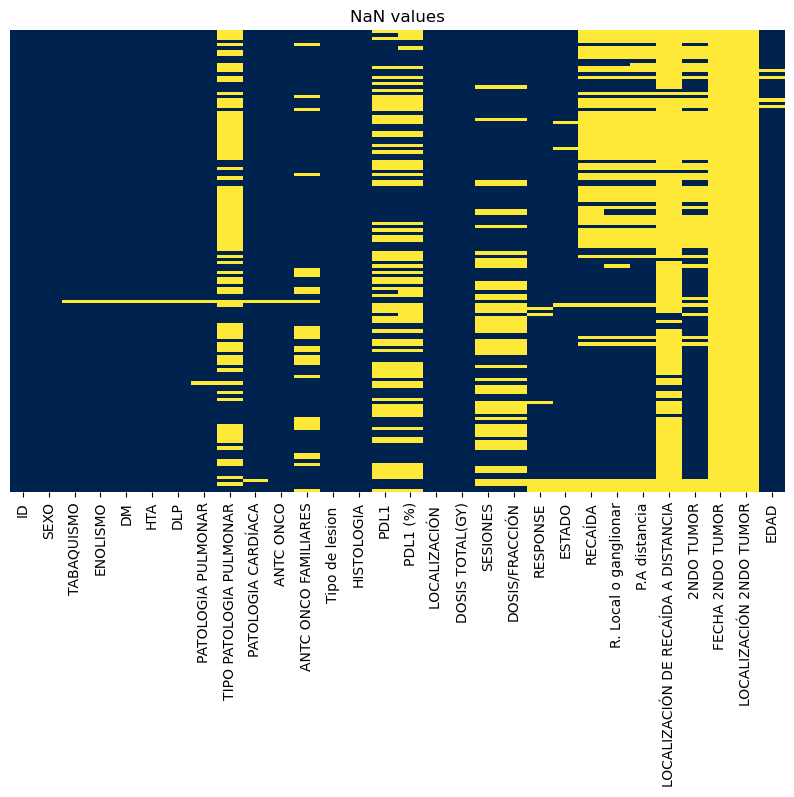

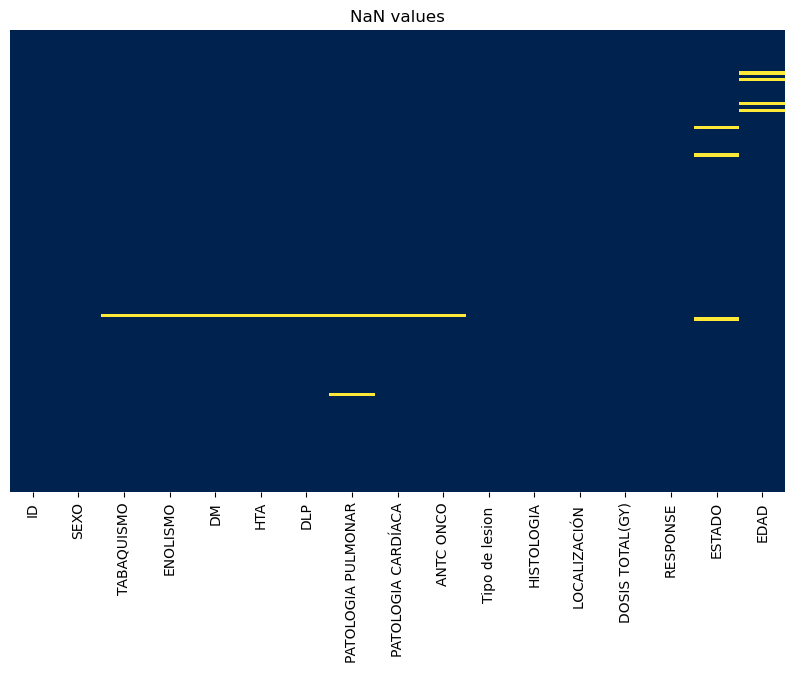

In [20]:
## Rename columns
df_clinical.rename(columns={"RESPUESTA POR TC A 1.5 MESES": "RESPONSE","ID TFM Marta":"ID" }, inplace=True)

## Age calculation
df_clinical['EDAD'] = (df_clinical['FECHA INICIO RT'] - df_clinical['Fecha nacimiento']).dt.days // 365

## Date variables elimination 
date_columns = df_clinical.select_dtypes(include=['datetime']).columns
print(date_columns)
df_clinical.drop(columns=date_columns, inplace=True)

## "No consta" relabeling to NA 
df_clinical.replace('No consta', np.nan, inplace=True)

## NAs count 
plt.figure(figsize=(10, 6))
sns.heatmap(df_clinical.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Variable filtering
if df_clinical.isna().sum().sum() > 0:
    #Since we want to predicr response, drop registies without response value
    df_clinical.dropna(subset=['RESPONSE'], inplace=True) 

    #Filter columns with more than a 10% of missing values
    nan_percentage = (df_clinical.isna().sum() / len(df_clinical)) * 100
    df_clinical_filtred = df_clinical.loc[:, nan_percentage < 10]

    #Plot the result
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_clinical_filtred.isna(), cbar=False, cmap='cividis', yticklabels=False)
    plt.title('NaN values')
    plt.show()

else:
    df_clinical_filtred = df_clinical
    print("No NA values in the DataFrame.")

# Clinical data description

In [21]:
df_clinical_data = df_clinical_filtred.drop(columns="ID")
numeric_variables = df_clinical_data.select_dtypes(include=['number']).columns
numeric_variables = numeric_variables.tolist()

categoric_variables = df_clinical_data.select_dtypes(include=['object', 'category']).columns
categoric_variables = categoric_variables.tolist()


table = to(df_clinical_data, categorical=categoric_variables, pval=False, nonnormal=numeric_variables)
print(table.tabulate(tablefmt = "fancy_grid"))
table.to_excel('descriptive_clinical.xlsx')

╒═════════════════════════════════╤══════════════════════════╤═══════════╤══════════════════╕
│                                 │                          │ Missing   │ Overall          │
╞═════════════════════════════════╪══════════════════════════╪═══════════╪══════════════════╡
│ n                               │                          │           │ 135              │
├─────────────────────────────────┼──────────────────────────┼───────────┼──────────────────┤
│ SEXO, n (%)                     │ Hombre                   │           │ 102 (75.6)       │
├─────────────────────────────────┼──────────────────────────┼───────────┼──────────────────┤
│                                 │ Mujer                    │           │ 33 (24.4)        │
├─────────────────────────────────┼──────────────────────────┼───────────┼──────────────────┤
│ TABAQUISMO, n (%)               │ Ex                       │           │ 47 (34.8)        │
├─────────────────────────────────┼─────────────────────────

# Data splitting

In [22]:
#Response variable to binary
df_clinical_filtred.loc[:, "RESPONSE"] = df_clinical_filtred["RESPONSE"].replace(
    {"Completa": 1, "Parcial ": 1, "Estable": 0, "Progresión": 0}
).astype(int)

df_clinical_filtred = df_clinical_filtred.drop(columns="ESTADO")
#Predictive variables
X = df_clinical_filtred.drop('RESPONSE', axis=1)

#Predicted variable
y = df_clinical_filtred['RESPONSE']  

## Training (80%) and testing (20%) splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024, stratify=y)

## Output dimensions
print(f'Training dataset: {X_train.shape}')
print(f'Testing dataset: {X_test.shape}') 

Training dataset: (108, 15)
Testing dataset: (27, 15)


C:\Users\pcbox\AppData\Local\Temp\ipykernel_4888\1985012860.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clinical_filtred.loc[:, "RESPONSE"] = df_clinical_filtred["RESPONSE"].replace(


# Clinical data preprocessing (after data splitting) 
## Data imputation

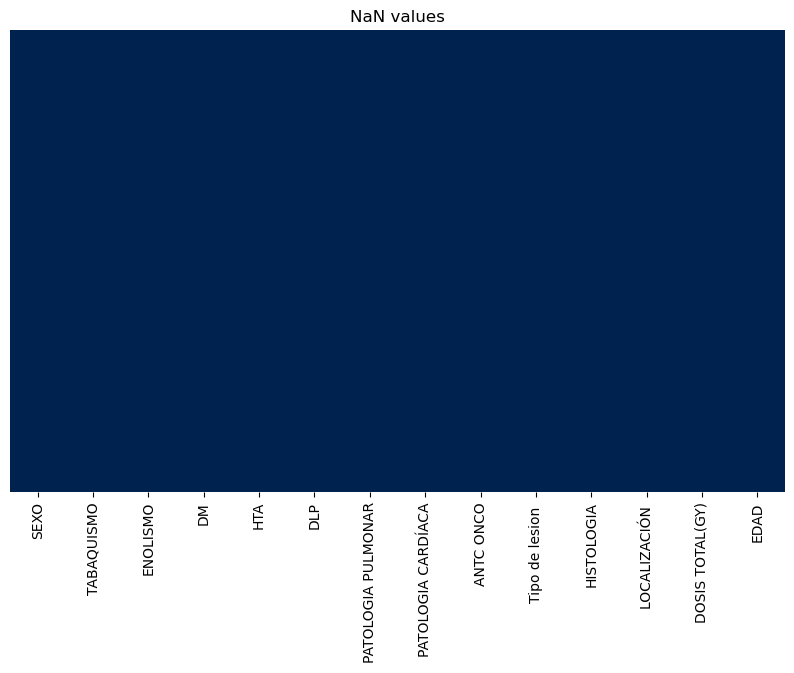

In [23]:
## Numeric data imputation 
X_train_data = X_train.drop(columns="ID")
X_test_data = X_test.drop(columns="ID")
numeric_variables = X_train_data.select_dtypes(include=['number']).columns
numeric_variables = numeric_variables.tolist()

num_imp= KNNImputer(n_neighbors=3) #KNN imputator takes into acconut the 3 nearest neighbors
X_train_data[numeric_variables] = num_imp.fit_transform(
    X_train_data[numeric_variables]
)
X_test_data[numeric_variables] = num_imp.transform(X_test_data[numeric_variables])

## Categoric data imputation 
categoric_variables = X_train_data.select_dtypes(include=['object', 'category']).columns
categoric_variables = categoric_variables.tolist()

cat_imp= SimpleImputer(strategy='most_frequent') 
X_train_data[categoric_variables] = cat_imp.fit_transform(
    X_train_data[categoric_variables]
)
X_test_data[categoric_variables] = cat_imp.transform(X_test_data[categoric_variables])

### Plot after data imputation
plt.figure(figsize=(10, 6))
sns.heatmap(X_train_data.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Data one-hot encoding

In [24]:
## One-hot encoding 
X_train_encoded = pd.get_dummies(X_train_data, columns=categoric_variables, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test_data, columns=categoric_variables, drop_first=True, dtype=int)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


In [25]:
X_train_encoded.shape

(108, 22)

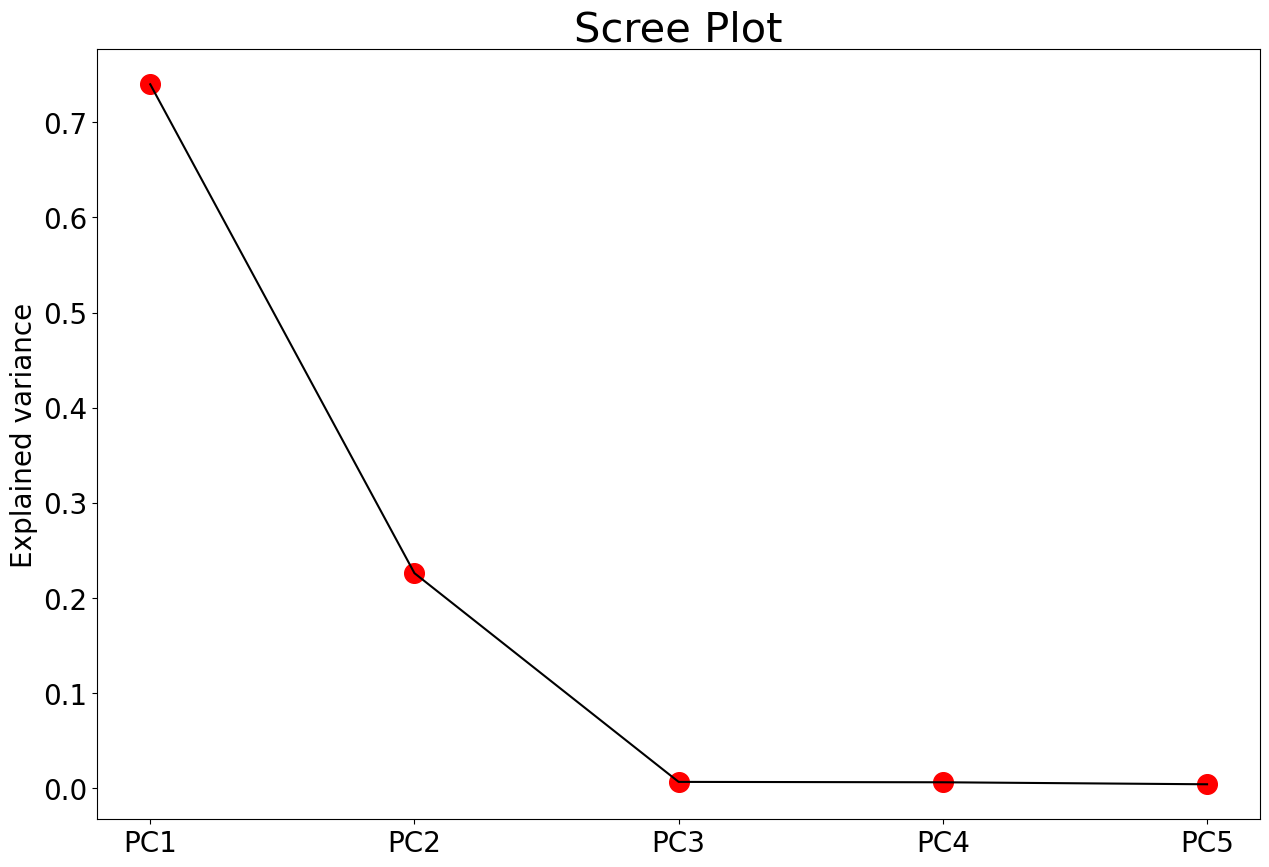

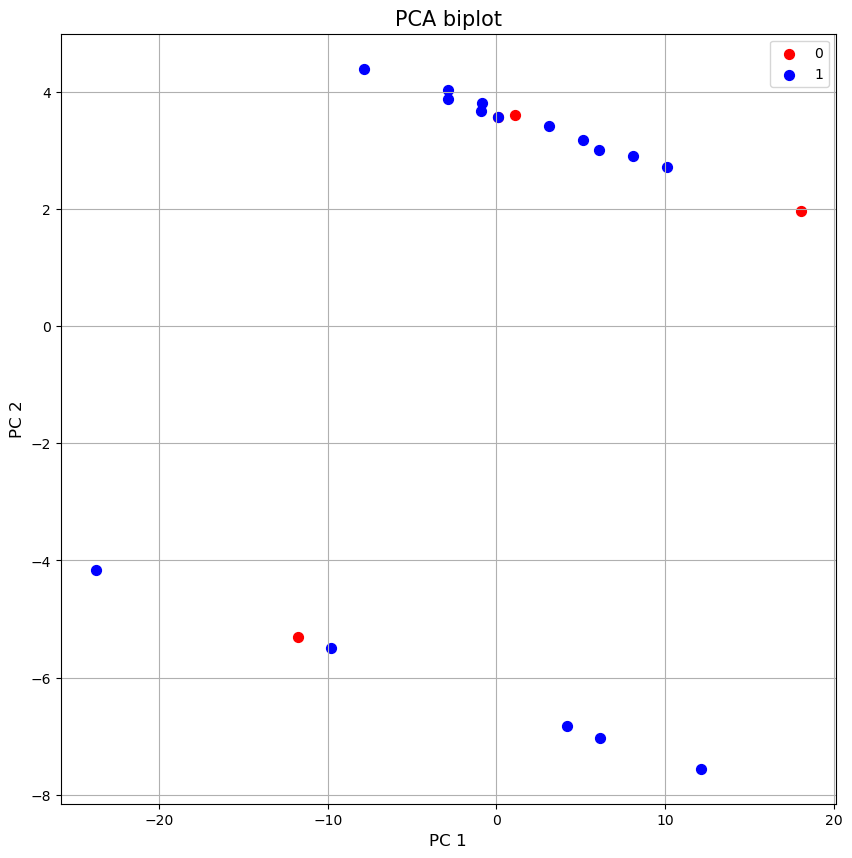

In [33]:
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(X_test_encoded)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
pca_fit_df['response'] = y_train

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()

# Radiomic data preprocessing (before data splitting)

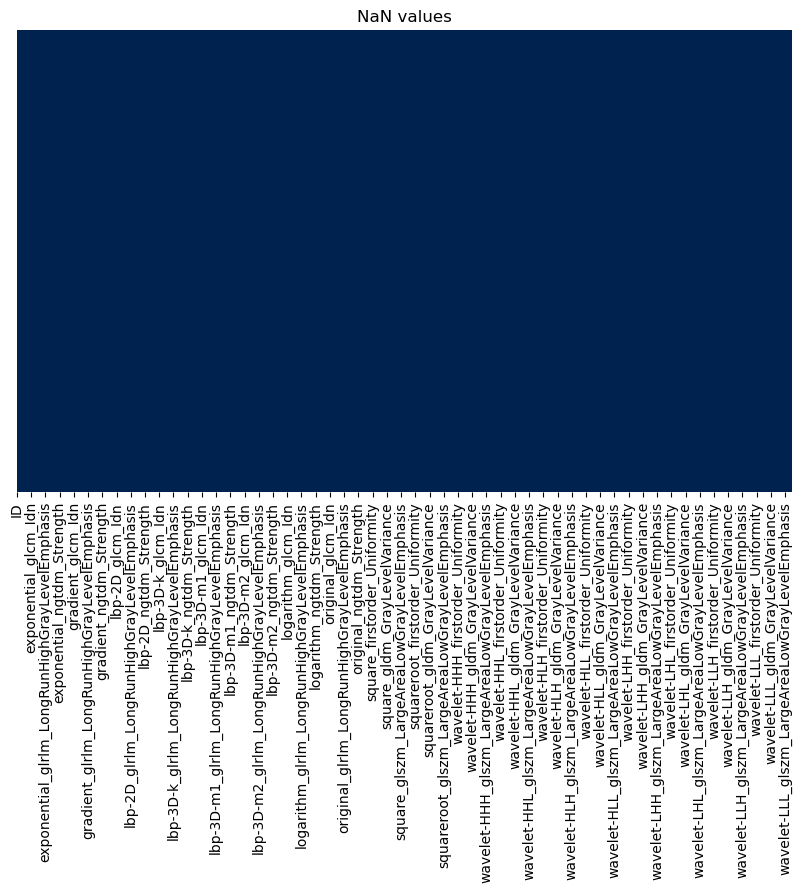

No NA values in the DataFrame.


In [26]:
#Eliminate index column
df_radiomic = df_radiomic.drop(df_radiomic.columns[0], axis=1)

## NAs count 
plt.figure(figsize=(10, 6))
sns.heatmap(df_radiomic.isna(), cbar=False, cmap='cividis', yticklabels=False)
plt.title('NaN values')
plt.show()

## Variable filtering
if df_radiomic.isna().sum().sum() > 0:
    nan_percentage = (df_radiomic.isna().sum() / len(df_radiomic)) * 100
    df_radiomic_filtred = df_radiomic.loc[:, nan_percentage < 10]

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_radiomic_filtred.isna(), cbar=False, cmap='cividis', yticklabels=False)
    plt.title('NaN values')
    plt.show()
else:
    df_radiomic_filtred = df_radiomic
    print("No NA values in the DataFrame.")

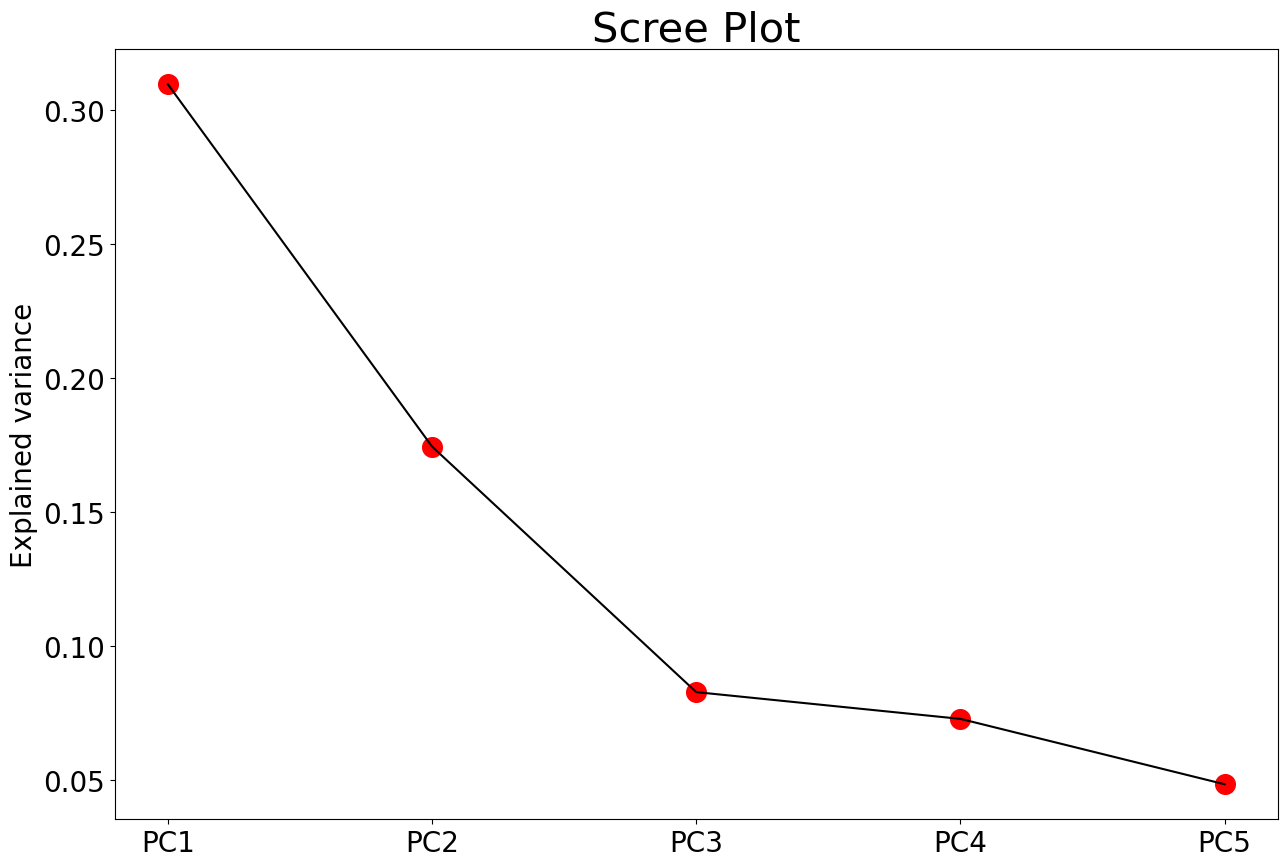

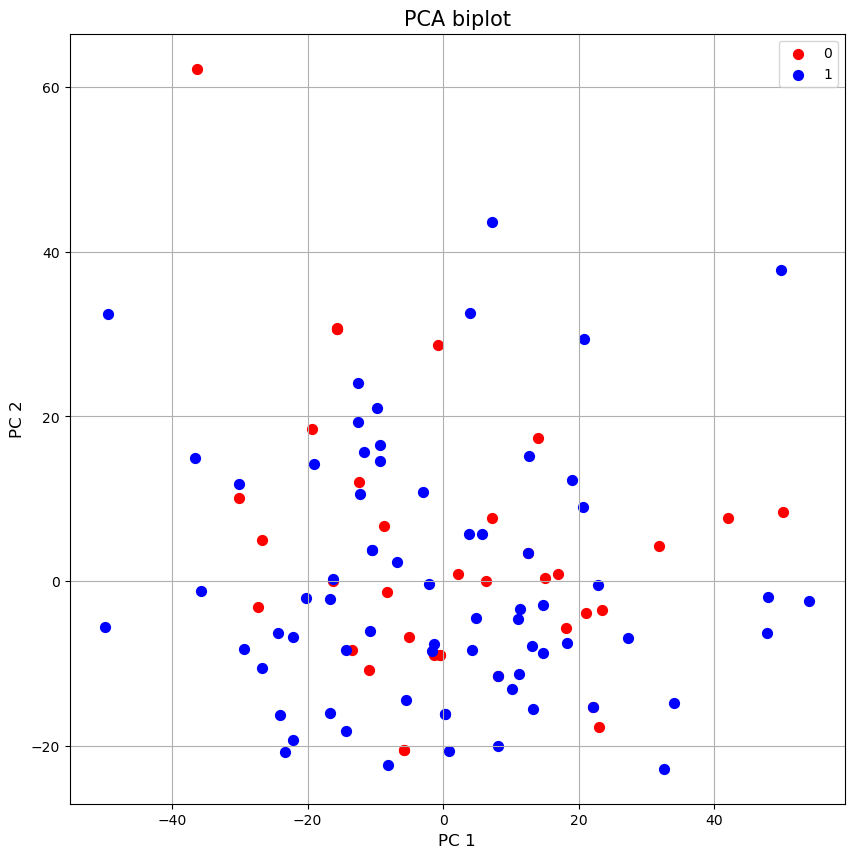

In [27]:
pca = PCA(n_components=5)
scaler = StandardScaler()
df_radiomic_scaled = scaler.fit_transform(df_radiomic)

# Aplicamos PCA con 5 componentes principales
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_radiomic_scaled)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
pca_fit_df['response'] = y_train

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()

# Radiomic data splitting

In [28]:
df_radiomic_train = df_radiomic_filtred[df_radiomic_filtred['ID'].isin(X_train['ID'])]
df_radiomic_test = df_radiomic_filtred[df_radiomic_filtred['ID'].isin(X_test['ID'])]

df_radiomic_train_data = df_radiomic_filtred.drop(columns='ID')
df_radiomic_test_data = df_radiomic_filtred.drop(columns='ID')

# Radiomic data preprocessing (after data splitting)

In [29]:
#Data preprocessing
##  Selection of discriminant and non redundant features
var = VarianceThreshold(threshold=0)  
df_radiomic_train_data_filter = var.fit_transform(df_radiomic_train_data)
df_radiomic_train_data_filter = pd.DataFrame(df_radiomic_train_data_filter, columns=df_radiomic_train_data.columns[var.get_support()])
print(f"Remaining features: {df_radiomic_train_data_filter.shape[1]}")

df_radiomic_test_data_filter = var.transform(df_radiomic_test_data)
df_radiomic_test_data_filter = pd.DataFrame(df_radiomic_test_data_filter, columns=df_radiomic_test_data.columns[var.get_support()])

X_train_reduced = df_radiomic_train_data_filter
X_test_reduced = df_radiomic_test_data_filter

print(f"Remaining features: {X_train_reduced.shape[1]}")
print(f"Remaining features: {X_test_reduced.shape[1]}")

Remaining features: 1558
Remaining features: 1558
Remaining features: 1558


# DATA MERGING

In [30]:
# Resetting indexes
## Training set
df_radiomic_train = df_radiomic_train.reset_index(drop=True)
X_train_reduced = X_train_reduced.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_train_encoded = X_train_encoded.reset_index(drop=True)

## Testing set
df_radiomic_test = df_radiomic_test.reset_index(drop=True)
X_test_reduced = X_test_reduced.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_test_encoded = X_test_encoded.reset_index(drop=True)

# Concatenating IDs
## Training set
training_clinical = pd.concat([X_train[['ID']], X_train_encoded], axis=1)
training_radiomic = pd.concat([df_radiomic_train[['ID']], X_train_reduced], axis=1)

### Ensuring the same ID type data in both dataframes
training_radiomic['ID'] = training_radiomic['ID'].astype(float)
training_clinical['ID'] = training_clinical['ID'].astype(float)

## Testing set
testing_clinical = pd.concat([X_test[['ID']], X_test_encoded], axis=1)
testing_radiomic = pd.concat([df_radiomic_test[['ID']], X_test_reduced], axis=1)

### Ensuring the same ID type data in both dataframes
testing_radiomic['ID'] = testing_radiomic['ID'].astype(float)
testing_clinical['ID'] = testing_clinical['ID'].astype(float)
testing_radiomic['ID'] = testing_radiomic['ID'].astype(float)
testing_clinical['ID'] = testing_clinical['ID'].astype(float)

# Df merging by ID
df_total_train = pd.merge(training_clinical, training_radiomic, on='ID', how='inner')
df_total_test = pd.merge(testing_clinical, testing_radiomic, on='ID', how='inner')
print(f'Merged dataset shape (train): {df_total_train.shape}')
print(f'Merged dataset shape (test): {df_total_test.shape}')

# Drop the "ID" column
df_total_train_data = df_total_train.drop(columns="ID")
df_total_test_data = df_total_test.drop(columns="ID")

# Check if the shapes are still correct after dropping "ID"
print(f"Training data shape (after dropping 'ID'): {df_total_train_data.shape}")
print(f"Testing data shape (after dropping 'ID'): {df_total_test_data.shape}")

# Make sure y is correctly set
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f"Training set shape after scaling: {df_total_train_data.shape}")
print(f"Testing set shape after scaling: {df_total_test_data.shape}")

Merged dataset shape (train): (108, 1581)
Merged dataset shape (test): (27, 1581)
Training data shape (after dropping 'ID'): (108, 1580)
Testing data shape (after dropping 'ID'): (27, 1580)
Training set shape after scaling: (108, 1580)
Testing set shape after scaling: (27, 1580)


In [31]:
df_total_train_data.describe()

,DOSIS TOTAL(GY),EDAD,SEXO_Mujer,TABAQUISMO_No,TABAQUISMO_Si,ENOLISMO_No,ENOLISMO_Si,DM_Si,HTA_Si,DLP_Si,...,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,55.851852,70.080247,0.231481,0.185185,0.481481,0.759259,0.194444,0.287037,0.620370,0.583333,...,2875.558879,0.003668,6.717380,0.599625,289.013785,0.038321,0.009600,22033.891511,0.871296,26.333541
std,4.835258,15.442848,0.423746,0.390259,0.501986,0.429526,0.397618,0.454488,0.487557,0.495305,...,1390.720101,0.004737,0.457689,0.161722,963.464425,0.028470,0.010778,11803.257651,0.739627,15.843784
min,48.000000,-45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,495.522692,0.000277,5.053509,0.217162,0.061587,0.007894,0.000476,6033.017891,0.034022,5.047843
25%,50.000000,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2044.128351,0.001416,6.516443,0.481807,1.557264,0.019290,0.002778,14619.347182,0.433698,15.294011
50%,60.000000,73.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,2638.200757,0.002118,6.708678,0.596380,15.913236,0.029582,0.005630,18920.557428,0.708113,22.075697
75%,60.000000,78.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,3419.557644,0.003608,6.960794,0.732675,124.323486,0.045314,0.010558,27837.277286,1.099374,35.211279
max,60.000000,87.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,8399.832956,0.032508,7.747315,0.938144,8305.189194,0.180396,0.057567,57179.897823,4.743194,94.607213


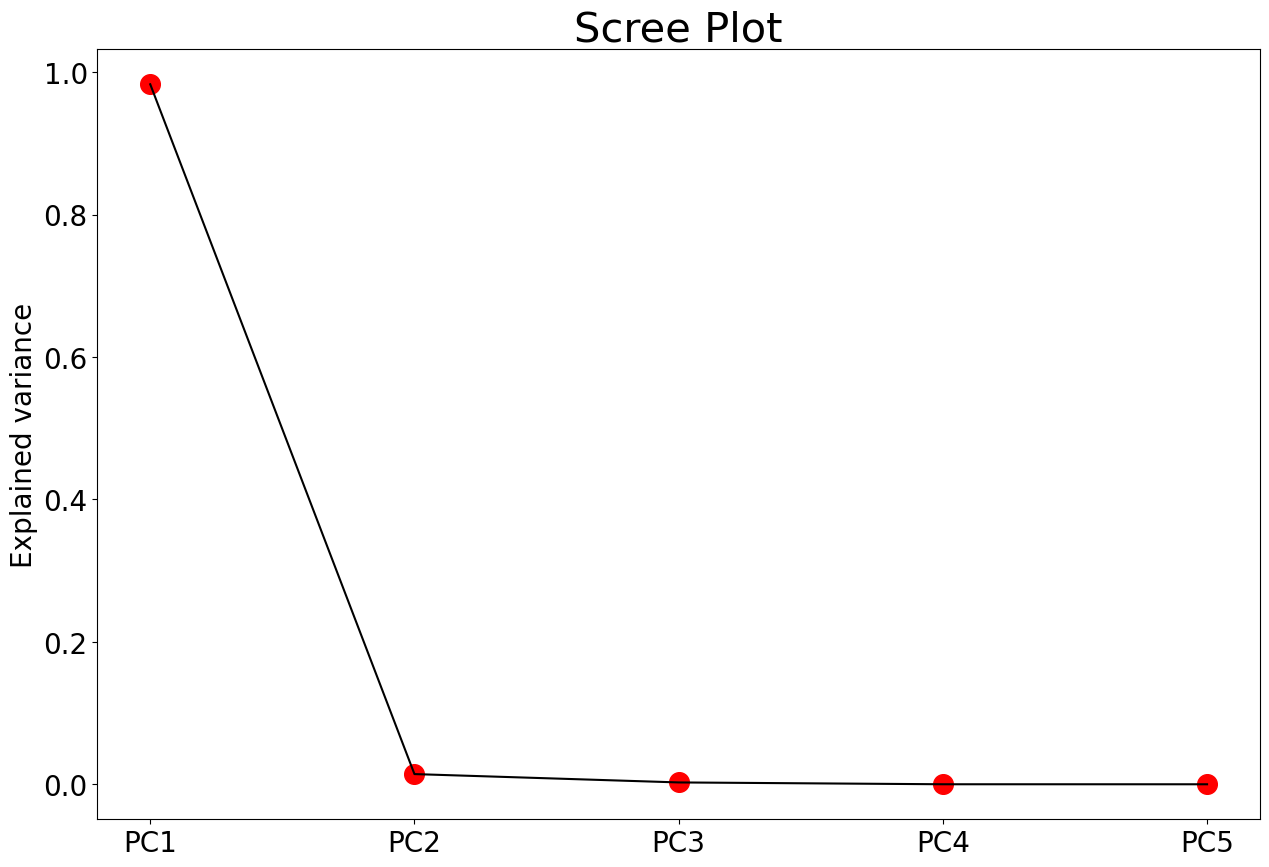

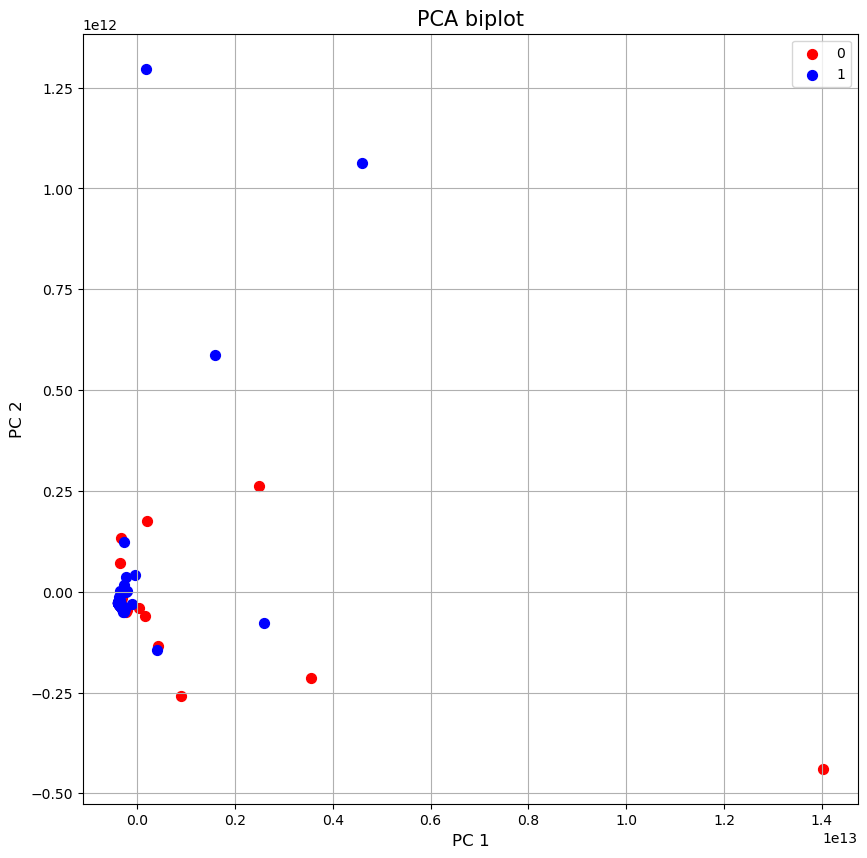

In [32]:
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_total_train_data)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
pca_fit_df['response'] = y_train

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()


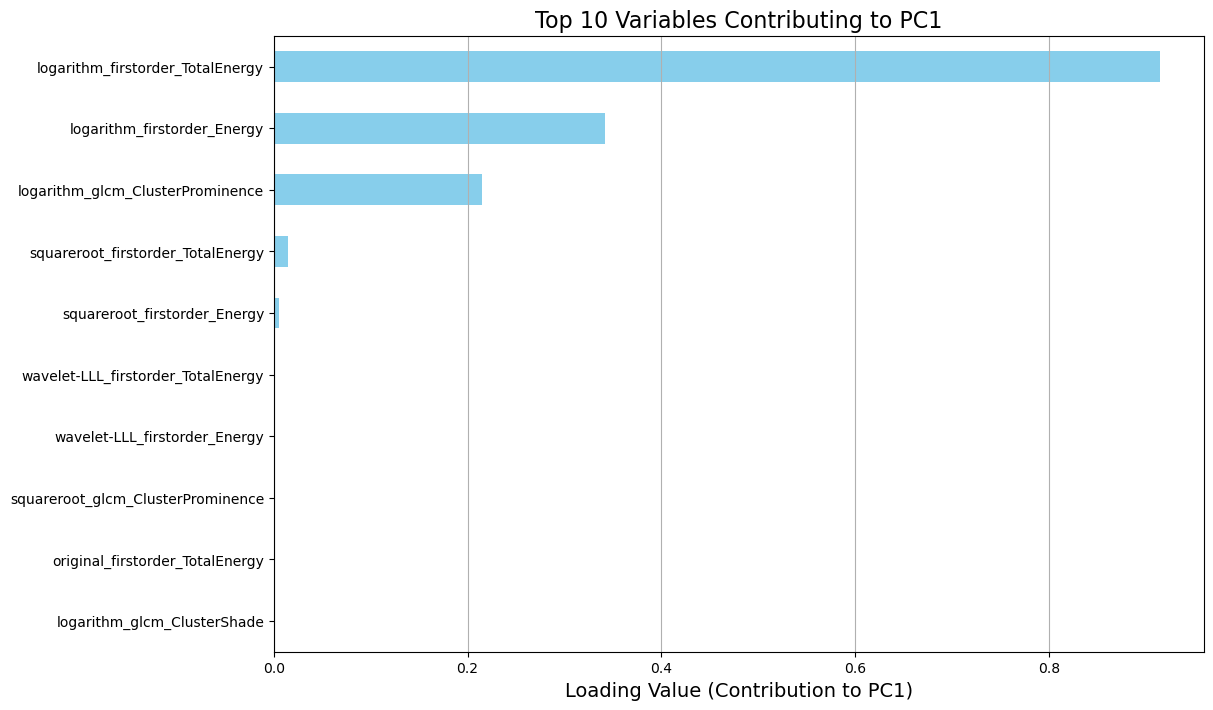

In [17]:
# Crear DataFrame con las cargas de cada variable en PC1
loadings = pd.DataFrame(pca.components_.T,  # Transpuesta para que cada columna sea un PC
                        columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                        index=df_total_train_data.columns)

# Ordenar las variables según la contribución absoluta al PC1
top_loadings_pc1 = loadings['PC1'].abs().sort_values(ascending=False)

# Visualizar las 10 principales variables que contribuyen al PC1
top_10_loadings = top_loadings_pc1.head(10)

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8))
top_10_loadings.plot(kind='barh', color='skyblue', ax=ax)
ax.set_xlabel('Loading Value (Contribution to PC1)', fontsize=14)
ax.set_title('Top 10 Variables Contributing to PC1', fontsize=16)
ax.invert_yaxis()  # Invertir el eje y para mostrar el valor más alto arriba
plt.grid(axis='x')
plt.show()

# Data preprocessing

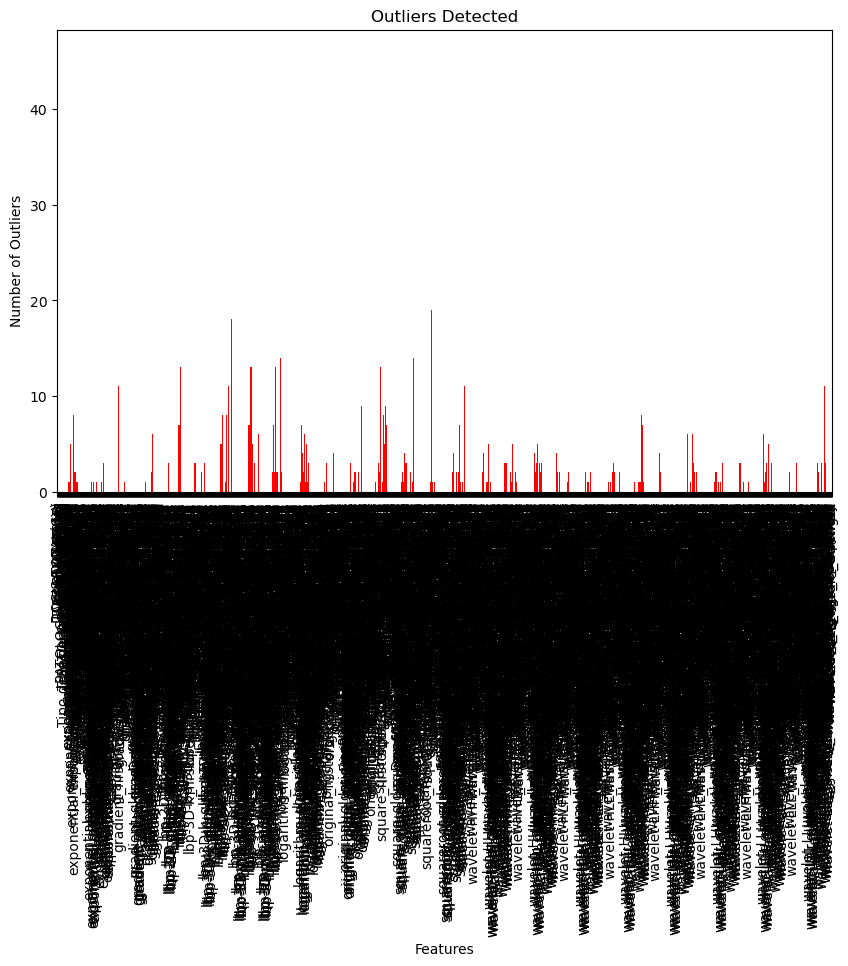

% Outliers detected: 1.41%


In [18]:
# Outlier class
class OutlierDetector(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=5):
        self.multiplier = multiplier

    def fit(self, X, y=None):
        # No se necesita hacer nada en el fit, ya que no hay parámetros a aprender
        return self

    def transform(self, X):
        X_out = X.copy()
        # Para cada columna numérica, detectar y reemplazar outliers con NaN
        for col in X_out.select_dtypes(include=['float64', 'int64']).columns:
            Q1 = X_out[col].quantile(0.25)
            Q3 = X_out[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.multiplier * IQR
            upper_bound = Q3 + self.multiplier * IQR
            # Reemplazar los outliers con NaN
            X_out[col] = np.where(
                (X_out[col] < lower_bound) | (X_out[col] > upper_bound),
                np.nan, 
                X_out[col]
            )
        return X_out

# Trying outlier class
outlier_detector = OutlierDetector()
df_total_train_data_outliers = outlier_detector.transform(df_total_train_data)
outliers_count = df_total_train_data_outliers.isna().sum()

# Outlier trying plot
plt.figure(figsize=(10, 6))
outliers_count.plot(kind='bar', color='red')
plt.title('Outliers Detected')
plt.ylabel('Number of Outliers')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

# % total outliers
outliers_count = df_total_train_data_outliers.isna().sum().sum() 
total_elements = df_total_train_data_outliers.size 
outliers_percentage = (outliers_count / total_elements) * 100
print(f"% Outliers detected: {outliers_percentage:.2f}%")

In [19]:
# Preprocessing pipeline 
categoric_variables = ['SEXO_Mujer', 'TABAQUISMO_No', 'TABAQUISMO_Si', 'ENOLISMO_No', 'ENOLISMO_Si', 'DM_Si', 'HTA_Si', 'DLP_Si', 'PATOLOGIA PULMONAR_Si', 'PATOLOGIA CARDÍACA_Si', 'ANTC ONCO_Si', 'Tipo de lesion _PD pulmón ', 'Tipo de lesion _Primario sin antc', 'HISTOLOGIA_CEC', 'HISTOLOGIA_NoAP', 'HISTOLOGIA_Otros', 'LOCALIZACIÓN _LII', 'LOCALIZACIÓN _LMD', 'LOCALIZACIÓN _LSD', 'LOCALIZACIÓN _LSI']
numeric_variables = [col for col in df_total_train_data.columns if col not in categoric_variables]

numeric_transformer = Pipeline(steps=[
    ('outlier_detector', OutlierDetector(multiplier=10)),  
    ('imputer', KNNImputer(n_neighbors=5)), 
    ('scaler', StandardScaler())
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
       ('num', numeric_transformer, numeric_variables), 
       ('cat', 'passthrough', categoric_variables), 
    ]
)

##Data preprocessing
df_total_train_data_preprocessed = preprocessing_pipeline.fit_transform(df_total_train_data)
df_total_train_data_preprocessed = pd.DataFrame(df_total_train_data_preprocessed, columns=numeric_variables + categoric_variables)

df_total_test_data_preprocessed = preprocessing_pipeline.transform(df_total_test_data)
df_total_test_data_preprocessed = pd.DataFrame(df_total_test_data_preprocessed, columns=numeric_variables + categoric_variables)


In [34]:
# Preprocessing pipeline 
categoric_variables = ['SEXO_Mujer', 'TABAQUISMO_No', 'TABAQUISMO_Si', 'ENOLISMO_No', 'ENOLISMO_Si', 'DM_Si', 'HTA_Si', 'DLP_Si', 'PATOLOGIA PULMONAR_Si', 'PATOLOGIA CARDÍACA_Si', 'ANTC ONCO_Si', 'Tipo de lesion _PD pulmón ', 'Tipo de lesion _Primario sin antc', 'HISTOLOGIA_CEC', 'HISTOLOGIA_NoAP', 'HISTOLOGIA_Otros', 'LOCALIZACIÓN _LII', 'LOCALIZACIÓN _LMD', 'LOCALIZACIÓN _LSD', 'LOCALIZACIÓN _LSI']
numeric_variables = [col for col in df_total_train_data.columns if col not in categoric_variables]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessing_pipeline = ColumnTransformer(
    transformers=[
       ('num', numeric_transformer, numeric_variables), 
       ('cat', 'passthrough', categoric_variables), 
    ]
)

##Data preprocessing
df_total_train_data_preprocessed = preprocessing_pipeline.fit_transform(df_total_train_data)
df_total_train_data_preprocessed = pd.DataFrame(df_total_train_data_preprocessed, columns=numeric_variables + categoric_variables)

df_total_test_data_preprocessed = preprocessing_pipeline.transform(df_total_test_data)
df_total_test_data_preprocessed = pd.DataFrame(df_total_test_data_preprocessed, columns=numeric_variables + categoric_variables)

In [20]:
pd.set_option('display.max_rows', None)  # Muestra todas las filas
df_total_train_data_outliers.isna().sum().sort_values(ascending=False)


lbp-2D_firstorder_InterquartileRange                     46
logarithm_glcm_ClusterShade                              35
lbp-2D_firstorder_10Percentile                           22
square_firstorder_Minimum                                20
squareroot_glcm_ClusterShade                             19
lbp-3D-m1_firstorder_Maximum                             18
lbp-3D-m1_firstorder_Range                               18
square_ngtdm_Coarseness                                  16
lbp-2D_firstorder_Median                                 16
square_glszm_LargeAreaEmphasis                           14
square_glszm_LargeAreaHighGrayLevelEmphasis              14
logarithm_firstorder_Kurtosis                            14
square_glszm_LargeAreaLowGrayLevelEmphasis               14
exponential_firstorder_Maximum                           13
lbp-3D-m1_glszm_SmallAreaEmphasis                        13
lbp-3D-m1_glszm_SmallAreaHighGrayLevelEmphasis           13
lbp-3D-m1_glszm_SmallAreaLowGrayLevelEmp

In [21]:
df_total_train_data_preprocessed

,DOSIS TOTAL(GY),EDAD,exponential_firstorder_10Percentile,exponential_firstorder_90Percentile,exponential_firstorder_Energy,exponential_firstorder_Entropy,exponential_firstorder_InterquartileRange,exponential_firstorder_Kurtosis,exponential_firstorder_Maximum,exponential_firstorder_Mean,...,ANTC ONCO_Si,Tipo de lesion _PD pulmón,Tipo de lesion _Primario sin antc,HISTOLOGIA_CEC,HISTOLOGIA_NoAP,HISTOLOGIA_Otros,LOCALIZACIÓN _LII,LOCALIZACIÓN _LMD,LOCALIZACIÓN _LSD,LOCALIZACIÓN _LSI
0,-1.215888,0.255007,0.554849,-0.218689,-0.269337,9.860761e-32,-0.421507,-0.597353,-0.473875,0.166494,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.861896,0.580290,-1.064463,0.351417,-0.476059,9.860761e-32,1.272325,-0.547598,-0.215161,-0.279016,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.215888,-0.070277,1.256530,-0.074374,0.866299,9.860761e-32,-1.308418,0.428935,-0.487919,0.849219,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.384775,-0.460618,0.472820,-0.283889,-0.322411,9.860761e-32,-0.476782,-0.278964,-0.557456,0.141616,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.861896,-0.525675,-1.206760,0.172539,0.102018,9.860761e-32,1.274201,1.637662,-0.239645,-0.869002,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.861896,0.580290,-1.895467,-6.979828,-0.615783,9.860761e-32,-1.395289,3.085394,-0.986695,-4.182838,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,-1.215888,0.580290,-0.301397,0.772787,0.813122,9.860761e-32,0.256178,-0.254340,-0.138000,0.511823,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7,-1.631445,0.320063,-0.150465,0.745931,2.575510,9.860761e-32,-0.396878,-0.000175,0.676888,0.727445,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,-1.215888,-0.005221,-0.859431,0.455113,-0.329860,9.860761e-32,1.479962,-0.629582,-0.240480,-0.305590,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.861896,-0.460618,-0.425190,0.636559,-0.490533,9.860761e-32,0.415806,-0.314825,-0.163922,0.224123,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
print(numeric_variables)
print(categoric_variables)
print(df_total_train_data.columns.tolist())


['DOSIS TOTAL(GY)', 'EDAD', 'exponential_firstorder_10Percentile', 'exponential_firstorder_90Percentile', 'exponential_firstorder_Energy', 'exponential_firstorder_Entropy', 'exponential_firstorder_InterquartileRange', 'exponential_firstorder_Kurtosis', 'exponential_firstorder_Maximum', 'exponential_firstorder_Mean', 'exponential_firstorder_MeanAbsoluteDeviation', 'exponential_firstorder_Median', 'exponential_firstorder_Minimum', 'exponential_firstorder_Range', 'exponential_firstorder_RobustMeanAbsoluteDeviation', 'exponential_firstorder_RootMeanSquared', 'exponential_firstorder_Skewness', 'exponential_firstorder_TotalEnergy', 'exponential_firstorder_Uniformity', 'exponential_firstorder_Variance', 'exponential_glcm_Autocorrelation', 'exponential_glcm_ClusterProminence', 'exponential_glcm_ClusterShade', 'exponential_glcm_ClusterTendency', 'exponential_glcm_Contrast', 'exponential_glcm_Correlation', 'exponential_glcm_DifferenceAverage', 'exponential_glcm_DifferenceEntropy', 'exponential_g

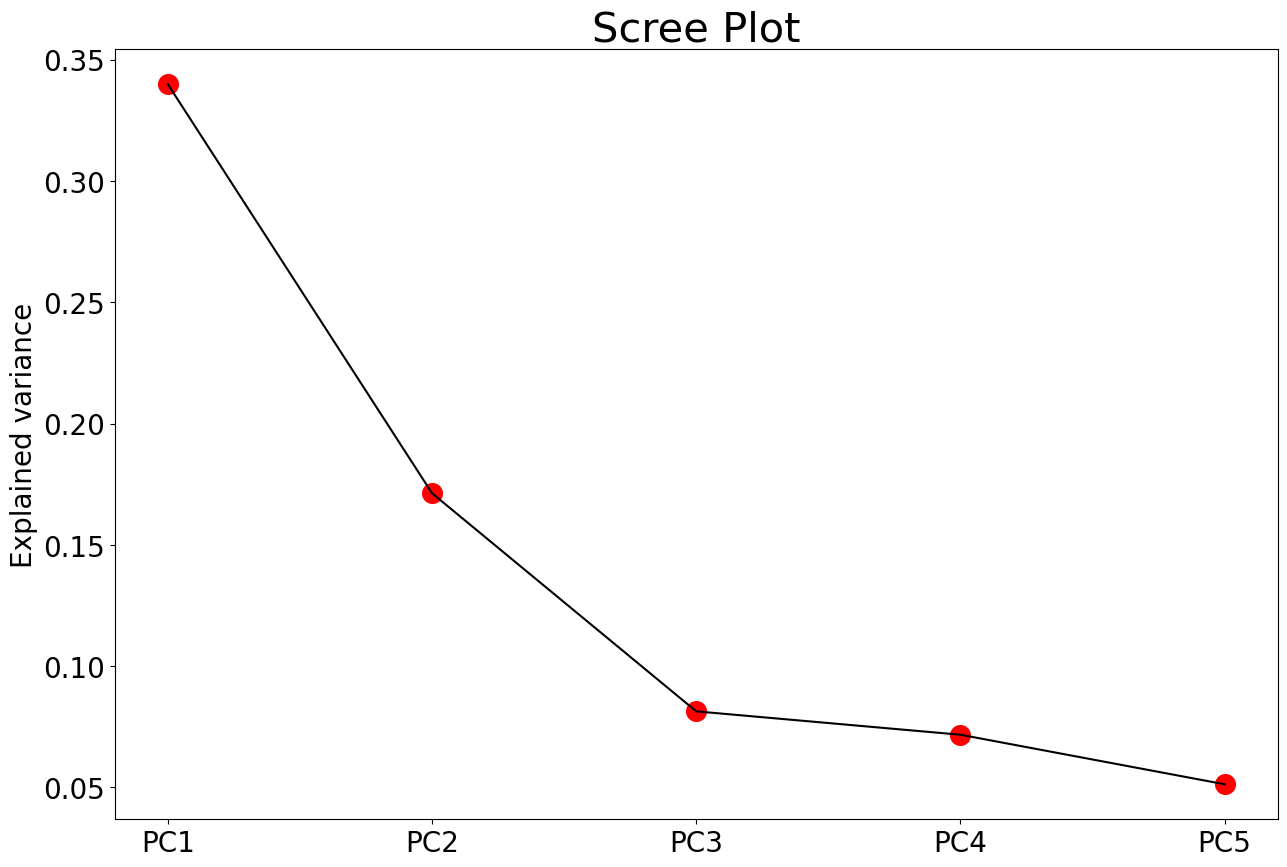

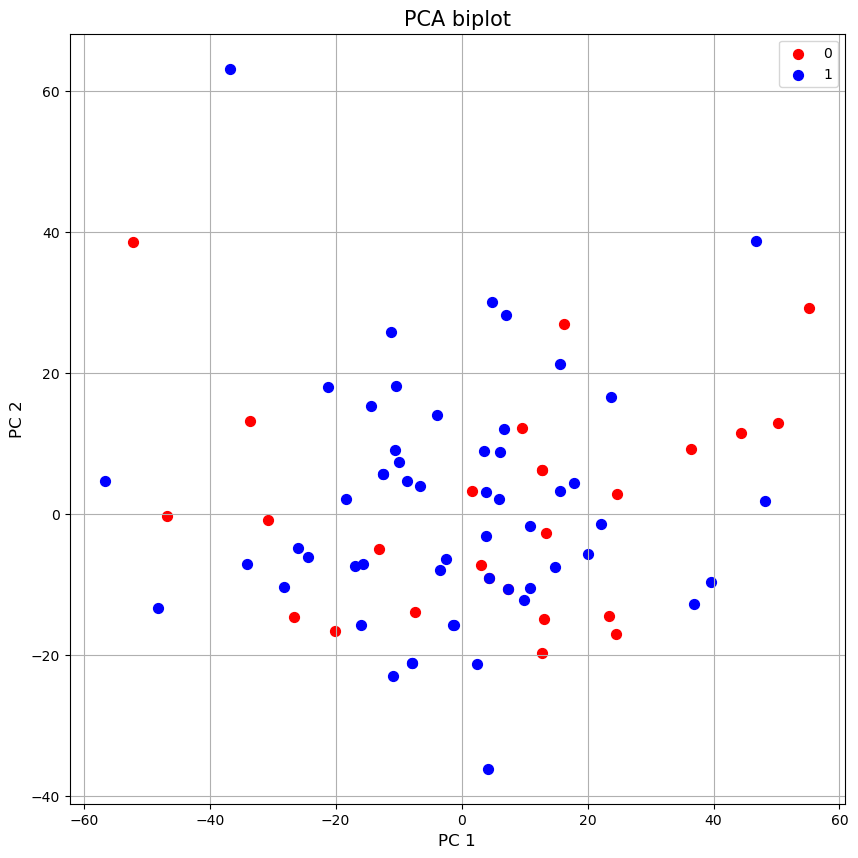

In [23]:
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_total_train_data_preprocessed)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
pca_fit_df['response'] = y_train

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()

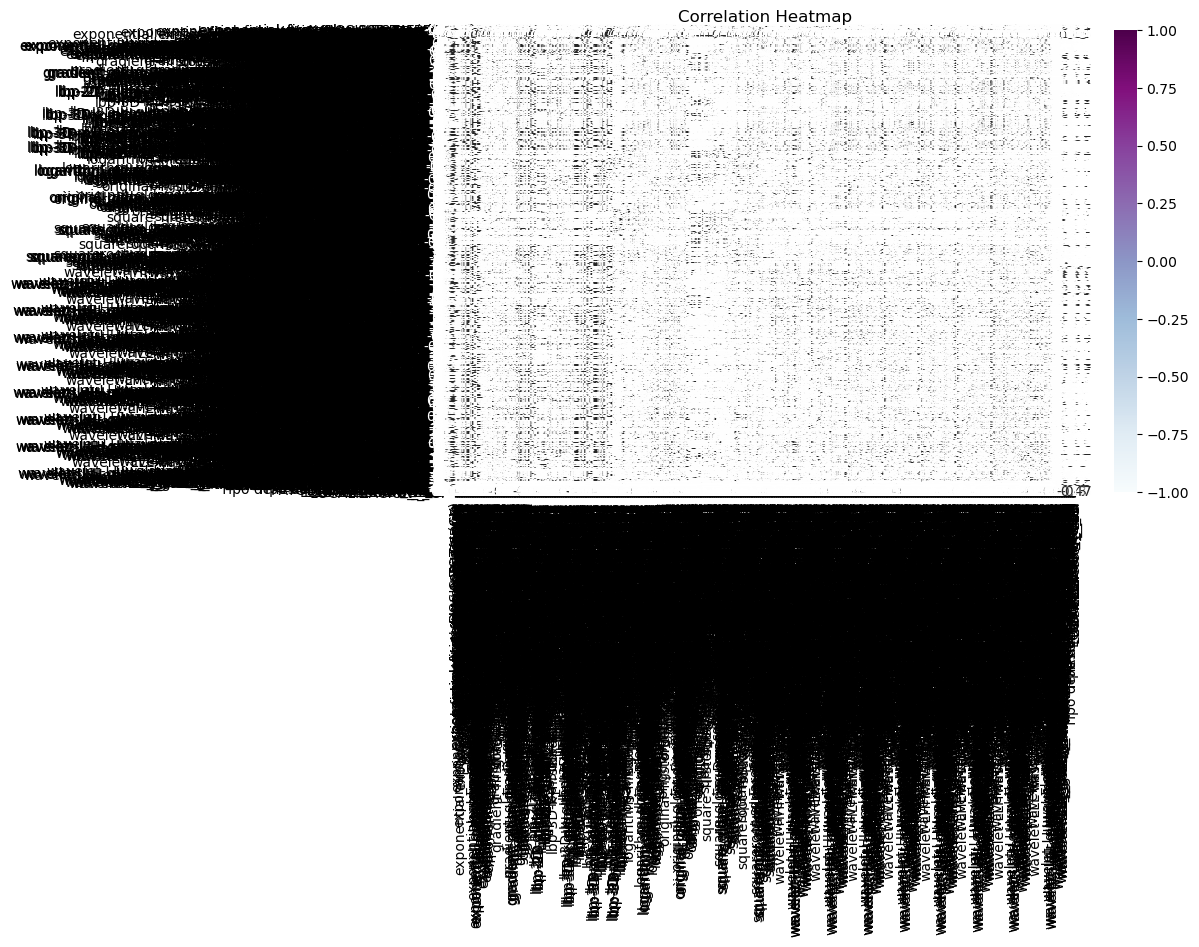

In [24]:
corr = df_total_train_data_preprocessed.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="BuPu",
            vmin=-1,
            vmax=1,
            annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [35]:
df_total_train_data_preprocessed.to_excel("Preprocessed_data_train.xlsx")
df_total_train_data_preprocessed.shape

df_total_test_data_preprocessed.to_excel("Preprocessed_data_test.xlsx")
df_total_test_data_preprocessed.shape

y_train.to_excel("y_train.xlsx")
y_test.to_excel("y_test.xlsx")


# Feature selection 
## LASSO

In [49]:
# Lasso
lasso_cv = LassoCV(cv=5, random_state=2024)
lasso_cv.fit(df_total_train_data, y_train)
lasso_selected = lasso_cv.coef_ != 0 
X_train_lasso = df_total_train_data.loc[:, lasso_selected] 
X_test_lasso = df_total_test_data.loc[:, lasso_selected] 
print("Shape of LASSO-selected data:", X_train_lasso.shape)
lasso_selected_features = df_total_train_data.columns[lasso_selected]
print("Selected features:", lasso_selected_features)

c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.369e-03, tolerance: 1.966e-03
  model = cd_fast.enet_coordinate_descent(


Shape of LASSO-selected data: (108, 4)
Selected features: Index(['logarithm_firstorder_Energy', 'logarithm_firstorder_TotalEnergy',
       'logarithm_glcm_ClusterProminence',
       'wavelet-LLL_firstorder_TotalEnergy'],
      dtype='object')


## Random Forest 

In [50]:
## Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=2024)
rf_selector.fit(df_total_train_data, y_train)
importance = rf_selector.feature_importances_
X_train_rf = df_total_train_data.iloc[:, importance > 0]
X_test_rf = df_total_test_data[X_train_rf.columns]  
print("Shape of RF-selected data:", X_train_rf.shape)
print("Selected features:", X_train_rf.columns)

Shape of RF-selected data: (108, 814)
Selected features: Index(['DOSIS TOTAL(GY)', 'EDAD', 'SEXO_Mujer', 'ENOLISMO_No', 'ENOLISMO_Si',
       'HTA_Si', 'DLP_Si', 'PATOLOGIA CARDÍACA_Si', 'ANTC ONCO_Si',
       'Tipo de lesion _PD pulmón ',
       ...
       'wavelet-LLL_glrlm_RunVariance',
       'wavelet-LLL_glszm_GrayLevelNonUniformityNormalized',
       'wavelet-LLL_glszm_GrayLevelVariance',
       'wavelet-LLL_glszm_HighGrayLevelZoneEmphasis',
       'wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_ZoneEntropy', 'wavelet-LLL_glszm_ZoneVariance',
       'wavelet-LLL_ngtdm_Coarseness', 'wavelet-LLL_ngtdm_Complexity',
       'wavelet-LLL_ngtdm_Strength'],
      dtype='object', length=814)


In [51]:
## RFE
estimator = RandomForestClassifier(random_state=2024)
RFE_selector = RFE(estimator, n_features_to_select=10)  
RFE_selector.fit(df_total_train_data, y_train)
selected_features_mask = RFE_selector.support_  # Boolean mask of selected features
X_train_RFE = df_total_train_data.loc[:, selected_features_mask]
X_test_RFE = df_total_test_data[X_train_RFE.columns]  

print("Shape of RFE-selected data:", X_train_RFE.shape)
print("Selected features:", X_train_RFE.columns)

KeyboardInterrupt: 

## ANOVA

In [ ]:
## ANOVA
F_scores, p_values = f_classif(df_total_train_data, y_train)
anova_selected_features = p_values < 0.05
X_train_anova = df_total_train_data.loc[:, anova_selected_features]
X_test_anova = df_total_test_data[X_train_anova.columns]  

print("Shape of ANOVA-selected data:", X_train_anova.shape)
print("Selected features:", X_train_anova.columns)

Shape of ANOVA-selected data: (108, 113)
Selected features: Index(['PATOLOGIA CARDÍACA_Si', 'exponential_firstorder_Mean',
       'exponential_firstorder_Median', 'gradient_firstorder_Kurtosis',
       'gradient_glcm_Imc2', 'gradient_ngtdm_Strength',
       'lbp-3D-k_gldm_LargeDependenceEmphasis',
       'lbp-3D-k_gldm_SmallDependenceEmphasis',
       'lbp-3D-k_gldm_SmallDependenceHighGrayLevelEmphasis',
       'lbp-3D-k_glrlm_LongRunEmphasis',
       ...
       'wavelet-LLL_firstorder_Mean', 'wavelet-LLL_firstorder_Median',
       'wavelet-LLL_firstorder_RootMeanSquared',
       'wavelet-LLL_firstorder_TotalEnergy', 'wavelet-LLL_firstorder_Variance',
       'wavelet-LLL_glcm_ClusterTendency', 'wavelet-LLL_glcm_SumSquares',
       'wavelet-LLL_gldm_GrayLevelVariance',
       'wavelet-LLL_glrlm_GrayLevelVariance',
       'wavelet-LLL_glszm_GrayLevelVariance'],
      dtype='object', length=113)


c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 25  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  69  70  74  79  80  81  85  94  95  96
  97 101 102 103 107 109 110 111 112 113 114 208 211 213 216 217 246 250
 254 256 359 389 393 397 399 409 439 443 447 449 660] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
print("NaN en datos de entrenamiento:", df_total_train_data.isna().sum().sum())
print("Inf en datos de entrenamiento:", np.isinf(df_total_train_data).sum().sum())

NaN en datos de entrenamiento: 0
Inf en datos de entrenamiento: 0


In [ ]:
#!pip install feature-engine
from feature_engine.selection import MRMR

df_total_train_data = df_total_train_data.reindex 
y_train = y_train.reindex

# Now, you can proceed with MRMR feature selection
MRMR_selector = MRMR(method="MIQ", random_state=2024, max_features=10)
MRMR_selector.fit(df_total_train_data, y_train)
X_train_MRMR = MRMR_selector.transform(df_total_train_data)
X_test_MRMR = MRMR_selector.transform(df_total_test_data)

print("Shape of MRMR-selected data:", X_train_MRMR.shape)
print("Selected features:", X_train_MRMR.columns)

c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\User

Shape of MRMR-selected data: (108, 10)
Selected features: Index(['SEXO_Mujer', 'Tipo de lesion _Primario sin antc', 'LOCALIZACIÓN _LMD',
       'exponential_glcm_JointEnergy', 'exponential_glszm_GrayLevelVariance',
       'exponential_ngtdm_Busyness', 'gradient_glcm_MaximumProbability',
       'lbp-3D-m2_firstorder_Skewness',
       'lbp-3D-m2_glszm_GrayLevelNonUniformity',
       'wavelet-HLL_firstorder_Range'],
      dtype='object')


# Prediction models

In [ ]:
# List of feature sets
from sklearn.metrics import make_scorer, f1_score

# List of feature sets
feature_sets = {
    'ANOVA': X_train_anova,
    'LASSO': X_train_lasso,
    'RF': X_train_rf,
    'mRMR': X_train_MRMR
}

# List of classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=2024), 
    'GXBoost': GradientBoostingClassifier(random_state=2024)
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Store cross-validation results
cv_results = {}

# F1 score as the custom scoring metric
f1_scorer = make_scorer(f1_score, average='weighted')

# Loop through feature sets and classifiers
for feature_set_name, X_train_feature_set in feature_sets.items():
    print(f"\nEvaluating feature set: {feature_set_name}")
    
    for clf_name, clf in clfs.items():
        # Perform cross-validation for accuracy
        accuracy_scores = cross_val_score(clf, X_train_feature_set, y_train, cv=cv, scoring='accuracy')
        
        # Perform cross-validation for F1 score
        f1_scores = cross_val_score(clf, X_train_feature_set, y_train, cv=cv, scoring=f1_scorer)
        
        # Store results
        if feature_set_name not in cv_results:
            cv_results[feature_set_name] = {}

        cv_results[feature_set_name][clf_name] = {
            'mean_accuracy': np.mean(accuracy_scores),
            'std_accuracy': np.std(accuracy_scores),
            'mean_f1_score': np.mean(f1_scores),
            'std_f1_score': np.std(f1_scores)
        }

# Print the cross-validation results
for feature_set_name, feature_set_results in cv_results.items():
    print(f"\nResults for Feature Set: {feature_set_name}")
    for clf_name, result in feature_set_results.items():
        print(f"{clf_name}: Mean Accuracy = {result['mean_accuracy']:.4f}, Std Accuracy = {result['std_accuracy']:.4f}, "
              f"Mean F1 Score = {result['mean_f1_score']:.4f}, Std F1 Score = {result['std_f1_score']:.4f}")



Evaluating feature set: ANOVA

Evaluating feature set: LASSO

Evaluating feature set: RF

Evaluating feature set: mRMR

Results for Feature Set: ANOVA
RandomForest: Mean Accuracy = 0.6766, Std Accuracy = 0.0978, Mean F1 Score = 0.6560, Std F1 Score = 0.0800
LogisticRegression: Mean Accuracy = 0.6303, Std Accuracy = 0.0668, Mean F1 Score = 0.6032, Std F1 Score = 0.0618
KNN: Mean Accuracy = 0.6866, Std Accuracy = 0.0679, Mean F1 Score = 0.6254, Std F1 Score = 0.0827
SVM: Mean Accuracy = 0.7229, Std Accuracy = 0.0460, Mean F1 Score = 0.6768, Std F1 Score = 0.0357
GXBoost: Mean Accuracy = 0.6675, Std Accuracy = 0.1673, Mean F1 Score = 0.6595, Std F1 Score = 0.1544

Results for Feature Set: LASSO
RandomForest: Mean Accuracy = 0.5753, Std Accuracy = 0.0828, Mean F1 Score = 0.5716, Std F1 Score = 0.0732
LogisticRegression: Mean Accuracy = 0.7043, Std Accuracy = 0.0426, Mean F1 Score = 0.6593, Std F1 Score = 0.0424
KNN: Mean Accuracy = 0.7043, Std Accuracy = 0.0602, Mean F1 Score = 0.6819, St

In [ ]:
# FEATURE SELECTION (sum of different types) --------------------------------------------------------------------------------------------------------------------------------------------------------
# Variable names
feature_names = df_total_train_data.columns if isinstance(df_total_train_data, pd.DataFrame) else [f"Feature_{i}" for i in range(df_total_train_data.shape[1])]
print(feature_names)

# PCA filter
pca = PCA()
pca.fit(df_total_train_data)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
pca = PCA(n_components=n_components)
pca.fit(df_total_train_data)
loadings = np.abs(pca.components_)
pca_selected = np.any(loadings > 0, axis=0)

# Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=100)
mi_selector.fit(df_total_train_data, y_train)
mi_selected = mi_selector.get_support()  # Máscara booleana

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_total_train_data, y_train)
rf_selector = SelectFromModel(rf, threshold="mean")  # Selección según importancia media
rf_selected = rf_selector.get_support()  # Máscara booleana

# Lasso
lasso_cv = LassoCV(cv=5, random_state=2024)
lasso_cv.fit(df_total_train_data, y_train)
lasso_selected = lasso_cv.coef_ != 0  # Máscara booleana basada en coeficientes

# Presence/absence table: selected features for each feature selection method
selection_results = pd.DataFrame({
    "Feature": feature_names,  
    "PCA": pca_selected,       
    "Mutual_Information": mi_selected,  
    "Random_Forest": rf_selected,       
    "Lasso": lasso_selected   
})

# Summary of Total number of methods that selected each feature
selection_results["Selected_Count"] = selection_results.iloc[:, 1:].sum(axis=1)

# feature selection of those features selected by 4 methods
final_features = selection_results[selection_results["Selected_Count"] == 3]
print(final_features.shape)
print(final_features.head(4))
final_feature_names = final_features["Feature"].tolist()
print(final_feature_names)

Index(['DOSIS TOTAL(GY)', 'EDAD', 'SEXO_Mujer', 'TABAQUISMO_No',
       'TABAQUISMO_Si', 'ENOLISMO_No', 'ENOLISMO_Si', 'DM_Si', 'HTA_Si',
       'DLP_Si',
       ...
       'wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis',
       'wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_ZoneEntropy', 'wavelet-LLL_glszm_ZonePercentage',
       'wavelet-LLL_glszm_ZoneVariance', 'wavelet-LLL_ngtdm_Busyness',
       'wavelet-LLL_ngtdm_Coarseness', 'wavelet-LLL_ngtdm_Complexity',
       'wavelet-LLL_ngtdm_Contrast', 'wavelet-LLL_ngtdm_Strength'],
      dtype='object', length=1580)


c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-03, tolerance: 1.922e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e-03, tolerance: 1.983e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e-03, toleranc

(53, 6)
                                               Feature   PCA  \
0                                      DOSIS TOTAL(GY)  True   
117                         gradient_firstorder_Energy  True   
153                   gradient_glcm_MaximumProbability  True   
166  gradient_gldm_LargeDependenceLowGrayLevelEmphasis  True   

     Mutual_Information  Random_Forest  Lasso  Selected_Count  
0                  True           True  False               3  
117                True           True  False               3  
153                True           True  False               3  
166                True           True  False               3  
['DOSIS TOTAL(GY)', 'gradient_firstorder_Energy', 'gradient_glcm_MaximumProbability', 'gradient_gldm_LargeDependenceLowGrayLevelEmphasis', 'gradient_gldm_SmallDependenceLowGrayLevelEmphasis', 'lbp-2D_glszm_SmallAreaHighGrayLevelEmphasis', 'lbp-3D-k_glcm_Imc2', 'lbp-3D-k_glrlm_ShortRunEmphasis', 'lbp-3D-k_glszm_GrayLevelNonUniformityNormalized', 'log

In [ ]:
X_train_feature_set = df_total_train_data[final_feature_names]
print(X_train_feature_set.shape)

(108, 44)


In [ ]:
# List of feature sets
from sklearn.metrics import make_scorer, f1_score

# List of classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=2024), 
    'GXBoost': GradientBoostingClassifier(random_state=2024)
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Store cross-validation results
cv_results = {}

# F1 score as the custom scoring metric
f1_scorer = make_scorer(f1_score, average='weighted')

# Loop through feature sets and classifiers
for clf_name, clf in clfs.items():
    # Perform cross-validation for accuracy
    accuracy_scores = cross_val_score(clf, df_total_train_data, y_train, cv=cv, scoring='accuracy')
        
    # Perform cross-validation for F1 score
    f1_scores = cross_val_score(clf, df_total_train_data, y_train, cv=cv, scoring=f1_scorer)
        
    cv_results[clf_name] = {
        'mean_accuracy': np.mean(accuracy_scores),
        'std_accuracy': np.std(accuracy_scores),
        'mean_f1_score': np.mean(f1_scores),
        'std_f1_score': np.std(f1_scores)
        }

# Print the cross-validation results
for clf_name, result in cv_results.items():
    print(f"{clf_name}: Mean Accuracy = {result['mean_accuracy']:.4f}, Std Accuracy = {result['std_accuracy']:.4f}, "
            f"Mean F1 Score = {result['mean_f1_score']:.4f}, Std F1 Score = {result['std_f1_score']:.4f}")


RandomForest: Mean Accuracy = 0.6593, Std Accuracy = 0.1020, Mean F1 Score = 0.6375, Std F1 Score = 0.0908
LogisticRegression: Mean Accuracy = 0.6121, Std Accuracy = 0.0854, Mean F1 Score = 0.5989, Std F1 Score = 0.0883
KNN: Mean Accuracy = 0.5853, Std Accuracy = 0.0976, Mean F1 Score = 0.5419, Std F1 Score = 0.0943
SVM: Mean Accuracy = 0.6680, Std Accuracy = 0.0737, Mean F1 Score = 0.5825, Std F1 Score = 0.0868
GXBoost: Mean Accuracy = 0.6216, Std Accuracy = 0.1186, Mean F1 Score = 0.6042, Std F1 Score = 0.1159


In [ ]:
# FEATURE SELECTION (1r univariate, spearman, ALTRES) --------------------------------------------------------------------------------------------------------------------------------------------------------
from feature_engine.selection import SmartCorrelatedSelection
scs = SmartCorrelatedSelection(threshold=0.85, selection_method="variance")
scs.fit(df_total_train_data)
X_train_scs = scs.transform(df_total_train_data) 

df_total_train_data = X_train_scs

df_total_train_data = df_total_train_data.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Lasso
lasso_cv = LassoCV(cv=5, random_state=2024)
lasso_cv.fit(df_total_train_data, y_train)
lasso_selected = lasso_cv.coef_ != 0 
X_train_lasso = df_total_train_data.loc[:, lasso_selected] 
print("Shape of LASSO-selected data:", X_train_lasso.shape)
lasso_selected_features = df_total_train_data.columns[lasso_selected]
print("Selected features:", lasso_selected_features)

## Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=2024)
rf_selector.fit(df_total_train_data, y_train)
importance = rf_selector.feature_importances_
X_train_rf = df_total_train_data.iloc[:, importance > 0]
print("Shape of RF-selected data:", X_train_rf.shape)
print("Selected features:", X_train_rf.columns)

## ANOVA
F_scores, p_values = f_classif(df_total_train_data, y_train)
anova_selected_features = p_values < 0.05
X_train_anova = df_total_train_data.loc[:, anova_selected_features]

print("Shape of ANOVA-selected data:", X_train_anova.shape)
print("Selected features:", X_train_anova.columns)

# Now, you can proceed with MRMR feature selection
MRMR_selector = MRMR(method="MIQ", random_state=2024, max_features=10)
MRMR_selector.fit(df_total_train_data, y_train)
X_train_MRMR = MRMR_selector.transform(df_total_train_data)

print("Shape of MRMR-selected data:", X_train_MRMR.shape)
print("Selected features:", X_train_MRMR.columns)


# List of feature sets
from sklearn.metrics import make_scorer, f1_score

# List of feature sets
feature_sets = {
    'ANOVA': X_train_anova,
    'LASSO': X_train_lasso,
    'RF': X_train_rf,
    'mRMR': X_train_MRMR
}

# List of classifiers
clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=2024), 
    'GXBoost': GradientBoostingClassifier(random_state=2024)
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Store cross-validation results
cv_results = {}

# F1 score as the custom scoring metric
f1_scorer = make_scorer(f1_score, average='weighted')

# Loop through feature sets and classifiers
for feature_set_name, X_train_feature_set in feature_sets.items():
    print(f"\nEvaluating feature set: {feature_set_name}")
    
    for clf_name, clf in clfs.items():
        # Perform cross-validation for accuracy
        accuracy_scores = cross_val_score(clf, X_train_feature_set, y_train, cv=cv, scoring='accuracy')
        
        # Perform cross-validation for F1 score
        f1_scores = cross_val_score(clf, X_train_feature_set, y_train, cv=cv, scoring=f1_scorer)
        
        # Store results
        if feature_set_name not in cv_results:
            cv_results[feature_set_name] = {}

        cv_results[feature_set_name][clf_name] = {
            'mean_accuracy': np.mean(accuracy_scores),
            'std_accuracy': np.std(accuracy_scores),
            'mean_f1_score': np.mean(f1_scores),
            'std_f1_score': np.std(f1_scores)
        }

# Print the cross-validation results
for feature_set_name, feature_set_results in cv_results.items():
    print(f"\nResults for Feature Set: {feature_set_name}")
    for clf_name, result in feature_set_results.items():
        print(f"{clf_name}: Mean Accuracy = {result['mean_accuracy']:.4f}, Std Accuracy = {result['std_accuracy']:.4f}, "
              f"Mean F1 Score = {result['mean_f1_score']:.4f}, Std F1 Score = {result['std_f1_score']:.4f}")



c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.857e-03, tolerance: 1.922e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-03, tolerance: 1.922e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-03, toleranc

Shape of LASSO-selected data: (108, 1)
Selected features: Index(['square_ngtdm_Busyness'], dtype='object')
Shape of RF-selected data: (108, 432)
Selected features: Index(['DOSIS TOTAL(GY)', 'EDAD', 'SEXO_Mujer', 'ENOLISMO_No', 'HTA_Si',
       'DLP_Si', 'PATOLOGIA CARDÍACA_Si', 'ANTC ONCO_Si',
       'Tipo de lesion _PD pulmón ', 'Tipo de lesion _Primario sin antc',
       ...
       'wavelet-LLL_glcm_MaximumProbability',
       'wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis',
       'wavelet-LLL_glrlm_LongRunHighGrayLevelEmphasis',
       'wavelet-LLL_glrlm_RunEntropy', 'wavelet-LLL_glszm_LargeAreaEmphasis',
       'wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet-LLL_glszm_SmallAreaEmphasis', 'wavelet-LLL_glszm_ZoneEntropy',
       'wavelet-LLL_ngtdm_Complexity', 'wavelet-LLL_ngtdm_Strength'],
      dtype='object', length=432)
Shape of ANOVA-selected data: (108, 43)
Selected features: Index(['PATOLOGIA CARDÍACA_Si', 'gradient_firstorder_Kurtosis',
       'grad

c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\User

Shape of MRMR-selected data: (108, 10)
Selected features: Index(['TABAQUISMO_No', 'DM_Si', 'HISTOLOGIA_CEC', 'LOCALIZACIÓN _LSD',
       'exponential_glcm_Autocorrelation', 'exponential_glcm_JointEnergy',
       'exponential_glrlm_GrayLevelVariance', 'lbp-3D-k_glszm_ZoneEntropy',
       'logarithm_glcm_ClusterShade',
       'wavelet-HHL_glszm_SizeZoneNonUniformityNormalized'],
      dtype='object')

Evaluating feature set: ANOVA

Evaluating feature set: LASSO

Evaluating feature set: RF

Evaluating feature set: mRMR

Results for Feature Set: ANOVA
RandomForest: Mean Accuracy = 0.7411, Std Accuracy = 0.0526, Mean F1 Score = 0.7212, Std F1 Score = 0.0453
LogisticRegression: Mean Accuracy = 0.6017, Std Accuracy = 0.0946, Mean F1 Score = 0.5796, Std F1 Score = 0.0693
KNN: Mean Accuracy = 0.6771, Std Accuracy = 0.0521, Mean F1 Score = 0.6232, Std F1 Score = 0.0644
SVM: Mean Accuracy = 0.7416, Std Accuracy = 0.0588, Mean F1 Score = 0.6980, Std F1 Score = 0.0674
GXBoost: Mean Accuracy = 0.732

In [ ]:
from boruta import BorutaPy
rf = RandomForestClassifier(n_jobs=-1, class_weight=None, max_depth=7, random_state=0)
# Define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
feat_selector.fit(df_total_train_data, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1583
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1583
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1583
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1583
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1583
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1583
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1583
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	1582
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	1582
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	1582
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	1582
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	1582
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	1582
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	1582
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	1582
Iteration: 	16 / 100
Confirmed: 	0

BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=20,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x248CC44D940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x248CC44D940, verbose=2)

In [ ]:
pd.Series(y_train).value_counts()

RESPONSE
1    71
0    37
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.datasets import make_classification

# SMOTE
smote = SMOTE(random_state=2024, k_neighbors=5)
df_total_train_data_SMOTE, y_train_SMOTE = smote.fit_resample(df_total_train_data, y_train)

# ADASYN 
adasyn = ADASYN(random_state=2024, k_neighbors=5)
df_total_train_data_ADASYN, y_train_ADASYN = smote.fit_resample(df_total_train_data, y_train)

# Check that the oversampling has worked
print(Counter(y_train_SMOTE))
print(Counter(y_train_ADASYN))

NameError: name 'df_total_train_data' is not defined

In [ ]:
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(df_total_train_data_preprocessed)
pca_fit_df = pd.DataFrame(data = pca_fit,
                          columns = ['principal component 1',
                                     'principal component 2',
                                     'principal component 3',
                                     'principal component 4',
                                     'principal component 5'])
pca_fit_df['response'] = y_train

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, color='red', s=200)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),
         pca.explained_variance_ratio_, color='black')
plt.xticks(np.arange(len(pca.explained_variance_ratio_)),
           ['PC'+str(i) for i in range(1,6)], fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Explained variance', fontsize=20)
plt.title('Scree Plot',fontsize=30)
plt.show()

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 12)
ax.set_ylabel('PC 2', fontsize = 12)
ax.set_title('PCA biplot', fontsize = 15)
diags=[0,1]
colors=['r','b']
for diag, color in zip(diags,colors):
    i = pca_fit_df['response'] == diag
    ax.scatter(pca_fit_df.loc[i, 'principal component 1']
               , pca_fit_df.loc[i, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(diags)
ax.grid()